# A/B testing, traffic shifting and autoscaling

### Introduction

In this lab you will create an endpoint with multiple variants, splitting the traffic between them. Then after testing and reviewing the endpoint performance metrics, you will shift the traffic to one variant and configure it to autoscale.

### Table of Contents

- [1. Create an endpoint with multiple variants](#c3w2-1.)
  - [1.1. Construct Docker Image URI](#c3w2-1.1.)
    - [Exercise 1](#c3w2-ex-1)
  - [1.2. Create Amazon SageMaker Models](#c3w2-1.2.)
    - [Exercise 2](#c3w2-ex-2)
    - [Exercise 3](#c3w2-ex-3)
  - [1.3. Set up Amazon SageMaker production variants](#c3w2-1.3.)
    - [Exercise 4](#c3w2-ex-4)
    - [Exercise 5](#c3w2-ex-5)
  - [1.4. Configure and create endpoint](#c3w2-1.4.)
    - [Exercise 6](#c3w2-ex-6)
- [2. Test model](#c3w2-2.)
  - [2.1. Test the model on a few sample strings](#c3w2-2.1.)
    - [Exercise 7](#c3w2-ex-7)
  - [2.2. Generate traffic and review the endpoint performance metrics](#c3w2-2.2.)
- [3. Shift the traffic to one variant and review the endpoint performance metrics](#c3w2-3.)
  - [Exercise 8](#c3w2-ex-8)
- [4. Configure one variant to autoscale](#c3w2-4.)

Let's install and import the required modules.

In [2]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker==2.35.0
!conda install -q -y pytorch==1.6.0 -c pytorch
!pip install --disable-pip-version-check -q transformers==3.5.1

Keyring is skipped due to an exception: 'keyring.backends'
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pytorch==1.6.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.01.10 |       h06a4308_0         120 KB
    certifi-2022.12.7          |   py37h06a4308_0         150 KB
    cudatoolkit-10.2.89        |       hfd86e86_1       365.1 MB
    ninja-1.10.2               |       h06a4308_5           8 KB
    ninja-base-1.10.2          |       hd09550d_5         109 KB
    openssl-1.1.1t             |       h7f8727e_0         3.7 MB
    pytorch-1.6.0              |py3.7_cuda10.2.89_cudnn7.6.5_0       537.7 MB  pytorch
    ------------------------------------------------------------
           

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
import boto3
import sagemaker
import pandas as pd
import botocore

config = botocore.config.Config(user_agent_extra='dlai-pds/c3/w2')

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

cw = boto3.client(service_name='cloudwatch', 
                  config=config)

autoscale = boto3.client(service_name="application-autoscaling", 
                         config=config)

<a name='c3w2-1.'></a>
# 1. Create an endpoint with multiple variants

Two models trained to analyze customer feedback and classify the messages into positive (1), neutral (0), and negative (-1) sentiments are saved in the following S3 bucket paths. These `tar.gz` files contain the model artifacts, which result from model training.

In [5]:
model_a_s3_uri = 's3://dlai-practical-data-science/models/ab/variant_a/model.tar.gz'
model_b_s3_uri = 's3://dlai-practical-data-science/models/ab/variant_b/model.tar.gz'

Let's deploy an endpoint splitting the traffic between these two models 50/50 to perform A/B Testing. Instead of creating a PyTorch Model object and calling `model.deploy()` function, you will create an `Endpoint configuration` with multiple model variants. Here is the workflow you will follow to create an endpoint:

<img src="images/endpoint-workflow.png" width="60%" align="center">

<a name='c3w2-1.1.'></a>
### 1.1. Construct Docker Image URI

<img src="images/endpoint-workflow-1-image.png" width="60%" align="center">

You will need to create the models in Amazon SageMaker, which retrieves the URI for the pre-built SageMaker Docker image stored in Amazon Elastic Container Re
gistry (ECR). Let's construct the ECR URI which you will pass into the `create_model` function later.

Set the instance type. For the purposes of this lab, you will use a relatively small instance. Please refer to [this link](https://aws.amazon.com/sagemaker/pricing/) for additional instance types that may work for your use cases outside of this lab.

In [6]:
inference_instance_type = 'ml.m5.large'

<a name='c3w2-ex-1'></a>
### Exercise 1

Create an ECR URI using the `'PyTorch'` framework. Review other parameters of the image.

In [8]:
inference_image_uri = sagemaker.image_uris.retrieve(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    framework='pytorch', # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    version='1.6.0',
    instance_type=inference_instance_type,
    region=region,
    py_version='py3',
    image_scope='inference'
)
print(inference_image_uri)

763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.6.0-cpu-py3


<a name='c3w2-1.2.'></a>
### 1.2. Create Amazon SageMaker Models

<img src="images/endpoint-workflow-2-models.png" width="60%" align="center">

Amazon SageMaker Model includes information such as the S3 location of the model, the container image that can be used for inference with that model, the execution role, and the model name. 

Let's construct the model names.

In [9]:
import time
from pprint import pprint

timestamp = int(time.time())

model_name_a = '{}-{}'.format('a', timestamp)
model_name_b = '{}-{}'.format('b', timestamp)

You will use the following function to check if the model already exists in Amazon SageMaker.

In [10]:
def check_model_existence(model_name):
    for model in sm.list_models()['Models']:
        if model_name == model['ModelName']:
            return True
    return False

<a name='c3w2-ex-2'></a>
### Exercise 2

Create an Amazon SageMaker Model based on the `model_a_s3_uri` data.

**Instructions**: Use `sm.create_model` function, which requires the model name, Amazon SageMaker execution role and a primary container description (`PrimaryContainer` dictionary). The `PrimaryContainer` includes the S3 bucket location of the model artifacts (`ModelDataUrl` key) and ECR URI (`Image` key).

In [12]:
if not check_model_existence(model_name_a):
    model_a = sm.create_model(
        ModelName=model_name_a,
        ExecutionRoleArn=role,
        PrimaryContainer={
            ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
            'ModelDataUrl': model_a_s3_uri, # Replace None
            'Image': inference_image_uri # Replace None
            ### END SOLUTION - DO NOT delete this comment for grading purposes
        }
    )
    pprint(model_a)
else:
    print("Model {} already exists".format(model_name_a))

{'ModelArn': 'arn:aws:sagemaker:us-east-1:795941057495:model/a-1676422139',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '74',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Wed, 15 Feb 2023 00:50:25 GMT',
                                      'x-amzn-requestid': '7c3b8004-34d1-47b4-bc89-98c19996dcee'},
                      'HTTPStatusCode': 200,
                      'RequestId': '7c3b8004-34d1-47b4-bc89-98c19996dcee',
                      'RetryAttempts': 0}}


<a name='c3w2-ex-3'></a>
### Exercise 3

Create an Amazon SageMaker Model based on the `model_b_s3_uri` data.

**Instructions**: Use the example in the cell above.

In [13]:
if not check_model_existence(model_name_b):
    model_b = sm.create_model(
        ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
        ModelName=model_name_b, # Replace all None
        ExecutionRoleArn=role, # Replace all None
        ### END SOLUTION - DO NOT delete this comment for grading purposes
        PrimaryContainer={
            'ModelDataUrl': model_b_s3_uri, 
            'Image': inference_image_uri
        }
    )
    pprint(model_b)
else:
    print("Model {} already exists".format(model_name_b))

{'ModelArn': 'arn:aws:sagemaker:us-east-1:795941057495:model/b-1676422139',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '74',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Wed, 15 Feb 2023 00:50:58 GMT',
                                      'x-amzn-requestid': '0bf688de-b118-4c19-b118-bc8c6e79aeac'},
                      'HTTPStatusCode': 200,
                      'RequestId': '0bf688de-b118-4c19-b118-bc8c6e79aeac',
                      'RetryAttempts': 0}}


<a name='c3w2-1.3.'></a>
### 1.3. Set up Amazon SageMaker production variants

<img src="images/endpoint-workflow-3-variants.png" width="60%" align="center">

A production variant is a packaged SageMaker Model combined with the configuration related to how that model will be hosted. 

You have constructed the model in the section above. The hosting resources configuration includes information on how you want that model to be hosted: the number and type of instances, a pointer to the SageMaker package model, as well as a variant name and variant weight. A single SageMaker Endpoint can actually include multiple production variants.

<a name='c3w2-ex-4'></a>
### Exercise 4

Create an Amazon SageMaker production variant for the SageMaker Model with the `model_name_a`.

**Instructions**: Use the `production_variant` function passing the `model_name_a` and instance type defined above.

```python
variantA = production_variant(
    model_name=..., # SageMaker Model name
    instance_type=..., # instance type
    initial_weight=50, # traffic distribution weight
    initial_instance_count=1, # instance count
    variant_name='VariantA', # production variant name
)
```

In [14]:
from sagemaker.session import production_variant

variantA = production_variant(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    model_name=model_name_a, # Replace None
    instance_type=inference_instance_type, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    initial_weight=50,
    initial_instance_count=1,
    variant_name='VariantA',
)
print(variantA)

{'ModelName': 'a-1676422139', 'InstanceType': 'ml.m5.large', 'InitialInstanceCount': 1, 'VariantName': 'VariantA', 'InitialVariantWeight': 50}


<a name='c3w2-ex-5'></a>
### Exercise 5

Create an Amazon SageMaker production variant for the SageMaker Model with the `model_name_b`.

**Instructions**: See the required arguments in the cell above.

In [15]:
variantB = production_variant(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    model_name=model_name_b, # Replace all None
    instance_type=inference_instance_type, # Replace all None
    initial_weight=50, # Replace all None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    initial_instance_count=1,
    variant_name='VariantB'
)
print(variantB)

{'ModelName': 'b-1676422139', 'InstanceType': 'ml.m5.large', 'InitialInstanceCount': 1, 'VariantName': 'VariantB', 'InitialVariantWeight': 50}


<a name='c3w2-1.4.'></a>
### 1.4. Configure and create the endpoint

<img src="images/endpoint-workflow-4-configuration.png" width="60%" align="center">

You will use the following functions to check if the endpoint configuration and endpoint itself already exist in Amazon SageMaker.

In [16]:
def check_endpoint_config_existence(endpoint_config_name):
    for endpoint_config in sm.list_endpoint_configs()['EndpointConfigs']:
        if endpoint_config_name == endpoint_config['EndpointConfigName']:
            return True
    return False

def check_endpoint_existence(endpoint_name):
    for endpoint in sm.list_endpoints()['Endpoints']:
        if endpoint_name == endpoint['EndpointName']:
            return True
    return False

Create the endpoint configuration by specifying the name and pointing to the two production variants that you just configured that tell SageMaker how you want to host those models.

In [17]:
endpoint_config_name = '{}-{}'.format('ab', timestamp)

if not check_endpoint_config_existence(endpoint_config_name):
    endpoint_config = sm.create_endpoint_config(
        EndpointConfigName=endpoint_config_name, 
        ProductionVariants=[variantA, variantB]
    )
    pprint(endpoint_config)
else:
    print("Endpoint configuration {} already exists".format(endpoint_config_name))

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:795941057495:endpoint-config/ab-1676422139',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '94',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Wed, 15 Feb 2023 00:52:59 GMT',
                                      'x-amzn-requestid': '35125e6d-42f2-4267-9564-ee428b730aa6'},
                      'HTTPStatusCode': 200,
                      'RequestId': '35125e6d-42f2-4267-9564-ee428b730aa6',
                      'RetryAttempts': 0}}


<img src="images/endpoint-workflow-5-endpoint.png" width="60%" align="center">

Construct the endpoint name.

In [18]:
model_ab_endpoint_name = '{}-{}'.format('ab', timestamp)
print('Endpoint name: {}'.format(model_ab_endpoint_name))

Endpoint name: ab-1676422139


<a name='c3w2-ex-6'></a>
### Exercise 6

Create an endpoint with the endpoint name and configuration defined above.

In [19]:
if not check_endpoint_existence(model_ab_endpoint_name):
    endpoint_response = sm.create_endpoint(
        ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
        EndpointName=model_ab_endpoint_name, # Replace None
        EndpointConfigName=endpoint_config_name # Replace None
        ### END SOLUTION - DO NOT delete this comment for grading purposes
    )
    print('Creating endpoint {}'.format(model_ab_endpoint_name))
    pprint(endpoint_response)
else:
    print("Endpoint {} already exists".format(model_ab_endpoint_name))

Creating endpoint ab-1676422139
{'EndpointArn': 'arn:aws:sagemaker:us-east-1:795941057495:endpoint/ab-1676422139',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '81',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Wed, 15 Feb 2023 00:53:36 GMT',
                                      'x-amzn-requestid': 'e4fdc425-68b1-4211-8fa2-df4911b9193f'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'e4fdc425-68b1-4211-8fa2-df4911b9193f',
                      'RetryAttempts': 0}}


Review the created endpoint configuration in the AWS console.

**Instructions**:

- open the link
- notice that you are in the section Amazon SageMaker -> Endpoint configuration
- check the name of the endpoint configuration, its Amazon Resource Name (ARN) and production variants
- click on the production variants and check their container information: image and model data location

In [20]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpointConfig/{}">REST Endpoint configuration</a></b>'.format(
            region, endpoint_config_name
        )
    )
)

Review the created endpoint in the AWS console.

**Instructions**:

- open the link
- notice that you are in the section Amazon SageMaker -> Endpoints
- check the name of the endpoint, its ARN and status
- below you can review the monitoring metrics such as CPU, memory and disk utilization. Further down you can see the endpoint configuration settings with its production variants

In [21]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST endpoint</a></b>'.format(region, model_ab_endpoint_name)))

Wait for the endpoint to deploy.

### _This cell will take approximately 5-10 minutes to run._

In [22]:
%%time

waiter = sm.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=model_ab_endpoint_name)

CPU times: user 122 ms, sys: 22.9 ms, total: 145 ms
Wall time: 4min 1s


_Wait until the ^^ endpoint ^^ is deployed_

<a name='c3w2-2.'></a>
# 2. Test model

<a name='c3w2-2.1.'></a>
### 2.1. Test the model on a few sample strings

Here, you will pass sample strings of text to the endpoint in order to see the sentiment. You are given one example of each, however, feel free to play around and change the strings yourself!

<a name='c3w2-ex-7'></a>
### Exercise 7

Create an Amazon SageMaker Predictor based on the deployed endpoint.

**Instructions**: Use the `Predictor` object with the following parameters. Please pass JSON serializer and deserializer objects here, calling them with the functions `JSONLinesSerializer()` and `JSONLinesDeserializer()`, respectively. More information about the serializers can be found [here](https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html).

```python
predictor = Predictor(
    endpoint_name=..., # endpoint name
    serializer=..., # a serializer object, used to encode data for an inference endpoint
    deserializer=..., # a deserializer object, used to decode data from an inference endpoint
    sagemaker_session=sess
)
```

In [26]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONLinesSerializer
from sagemaker.deserializers import JSONLinesDeserializer

inputs = [
    {"features": ["I love this product!"]},
    {"features": ["OK, but not great."]},
    {"features": ["This is not the right product."]},
]

predictor = Predictor(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    endpoint_name=model_ab_endpoint_name, # Replace None
    serializer=JSONLinesSerializer(), # Replace None
    deserializer=JSONLinesDeserializer(), # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    sagemaker_session=sess
)

predicted_classes = predictor.predict(inputs)

for predicted_class in predicted_classes:
    print("Predicted class {} with probability {}".format(predicted_class['predicted_label'], predicted_class['probability']))

Predicted class 1 with probability 0.9605445861816406
Predicted class 0 with probability 0.5798221230506897
Predicted class -1 with probability 0.7667604684829712


<a name='c3w2-2.2.'></a>
### 2.2. Generate traffic and review the endpoint performance metrics

Now you will generate traffic. To analyze the endpoint performance you will review some of the metrics that Amazon SageMaker emits in CloudWatch: CPU Utilization, Latency and Invocations. Full list of namespaces and metrics can be found [here](https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html). CloudWatch `get_metric_statistics` documentation can be found [here](https://docs.aws.amazon.com/AmazonCloudWatch/latest/APIReference/API_GetMetricStatistics.html).

But before that, let's create a function that will help to extract the results from CloudWatch and plot them.

In [27]:
def plot_endpoint_metrics_for_variants(endpoint_name, 
                                       namespace_name, 
                                       metric_name, 
                                       variant_names, 
                                       start_time, 
                                       end_time):
    
    try:
        joint_variant_metrics = None

        for variant_name in variant_names:
            metrics = cw.get_metric_statistics( # extracts the results in a dictionary format
                Namespace=namespace_name, # the namespace of the metric, e.g. "AWS/SageMaker"
                MetricName=metric_name, # the name of the metric, e.g. "CPUUtilization"
                StartTime=start_time, # the time stamp that determines the first data point to return
                EndTime=end_time, # the time stamp that determines the last data point to return
                Period=60, # the granularity, in seconds, of the returned data points
                Statistics=["Sum"], # the metric statistics
                Dimensions=[ # dimensions, as CloudWatch treats each unique combination of dimensions as a separate metric
                    {"Name": "EndpointName", "Value": endpoint_name}, 
                    {"Name": "VariantName", "Value": variant_name}
                ],
            )
            
            if metrics["Datapoints"]: # access the results from the distionary using the key "Datapoints"
                df_metrics = pd.DataFrame(metrics["Datapoints"]) \
                    .sort_values("Timestamp") \
                    .set_index("Timestamp") \
                    .drop("Unit", axis=1) \
                    .rename(columns={"Sum": variant_name}) # rename the column with the metric results as a variant_name
                
                if joint_variant_metrics is None:
                    joint_variant_metrics = df_metrics
                else:
                    joint_variant_metrics = joint_variant_metrics.join(df_metrics, how="outer")
        
        joint_variant_metrics.plot(title=metric_name)
    except:
        pass

Establish wide enough time bounds to show all the charts using the same timeframe:

In [28]:
from datetime import datetime, timedelta

start_time = datetime.now() - timedelta(minutes=30)
end_time = datetime.now() + timedelta(minutes=30)

print('Start Time: {}'.format(start_time))
print('End Time: {}'.format(end_time))

Start Time: 2023-02-15 00:31:14.167533
End Time: 2023-02-15 01:31:14.167574


Set the list of the the variant names to analyze.

In [29]:
variant_names = [variantA["VariantName"], variantB["VariantName"]]

print(variant_names)

['VariantA', 'VariantB']


Run some predictions and view the metrics for each variant.

### _This cell will take approximately 1-2 minutes to run._

In [30]:
%%time

for i in range(0, 100):
    predicted_classes = predictor.predict(inputs)

CPU times: user 240 ms, sys: 11.8 ms, total: 251 ms
Wall time: 1min 28s


_Μake sure the predictions ^^ above ^^ ran successfully_

Let’s query CloudWatch to get a few metrics that are split across variants. If you see `Metrics not yet available`, please be patient as metrics may take a few mins to appear in CloudWatch.

In [31]:
time.sleep(30) # Sleep to accomodate a slight delay in metrics gathering

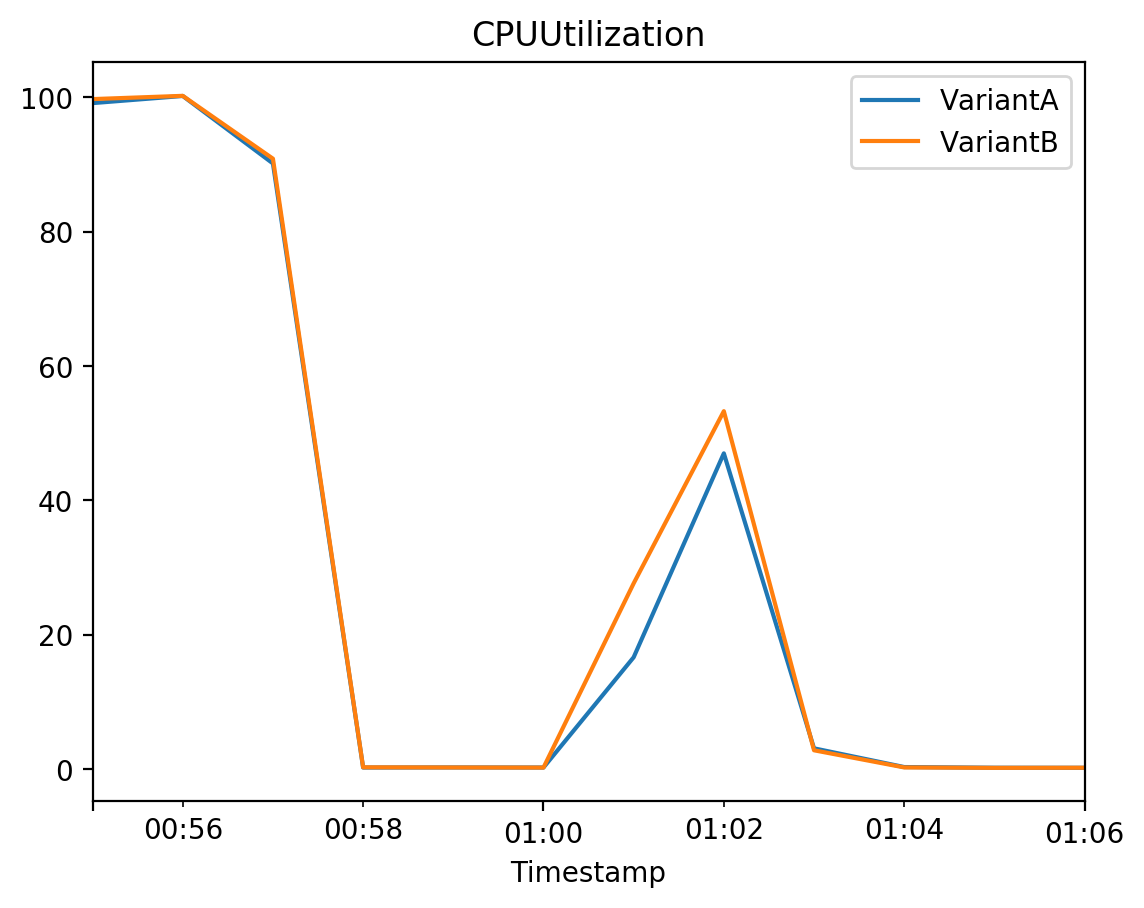

In [32]:
# CPUUtilization
# The sum of each individual CPU core's utilization. 
# The CPU utilization of each core can range between 0 and 100. For example, if there are four CPUs, CPUUtilization can range from 0% to 400%.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="/aws/sagemaker/Endpoints", 
    metric_name="CPUUtilization",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

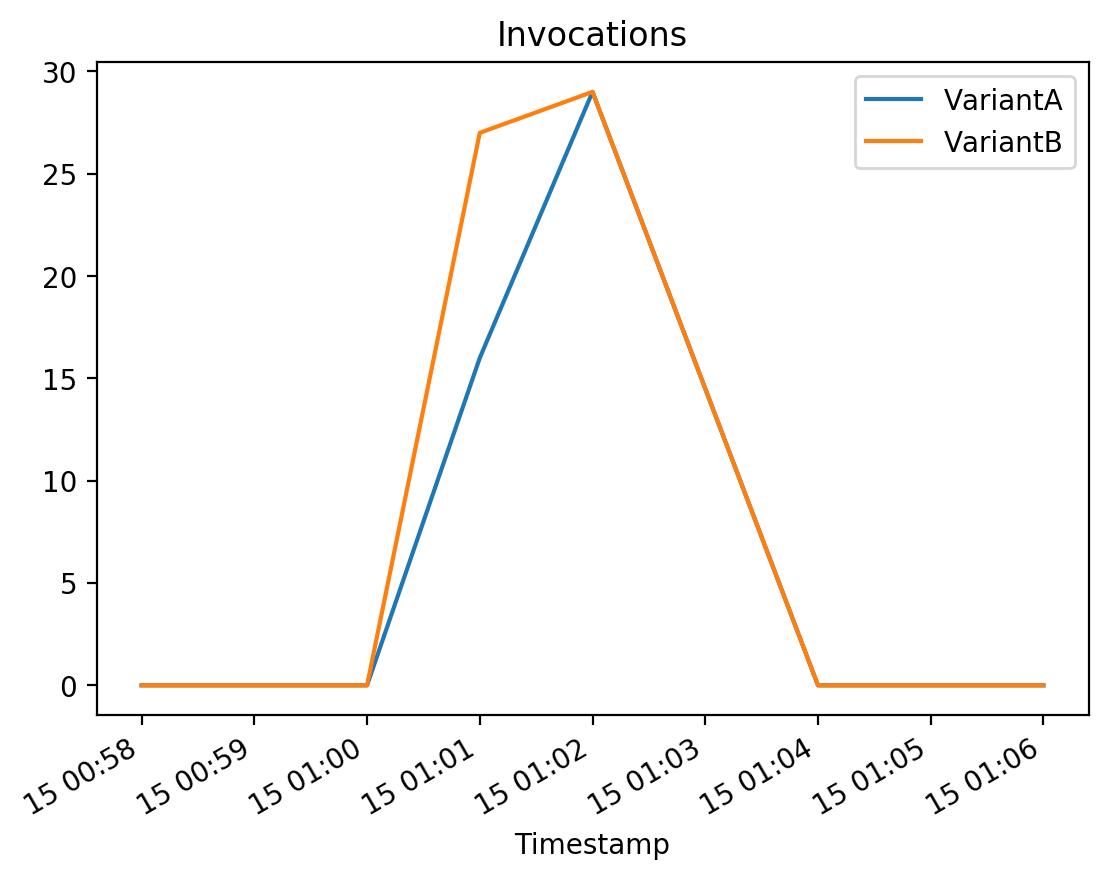

In [33]:
# Invocations
# The number of requests sent to a model endpoint.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="Invocations",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

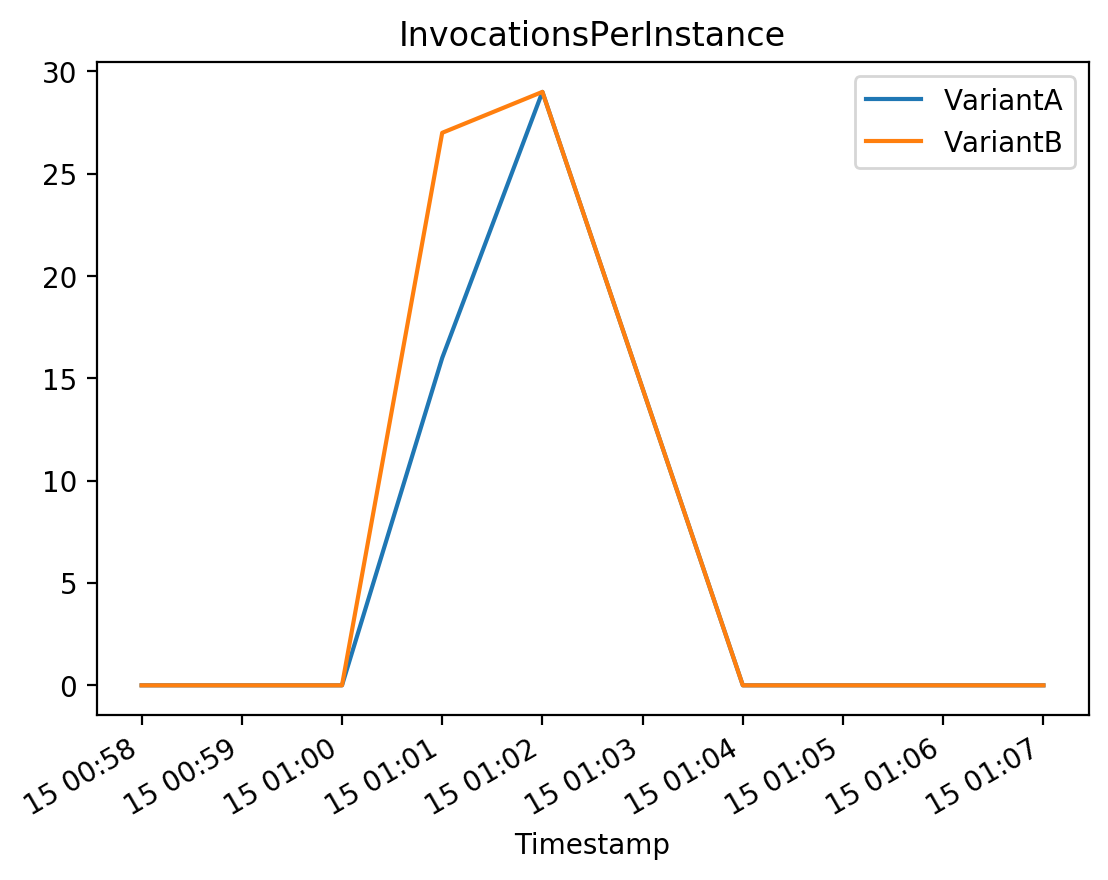

In [34]:
# InvocationsPerInstance
# The number of invocations sent to a model, normalized by InstanceCount in each production variant.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="InvocationsPerInstance",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

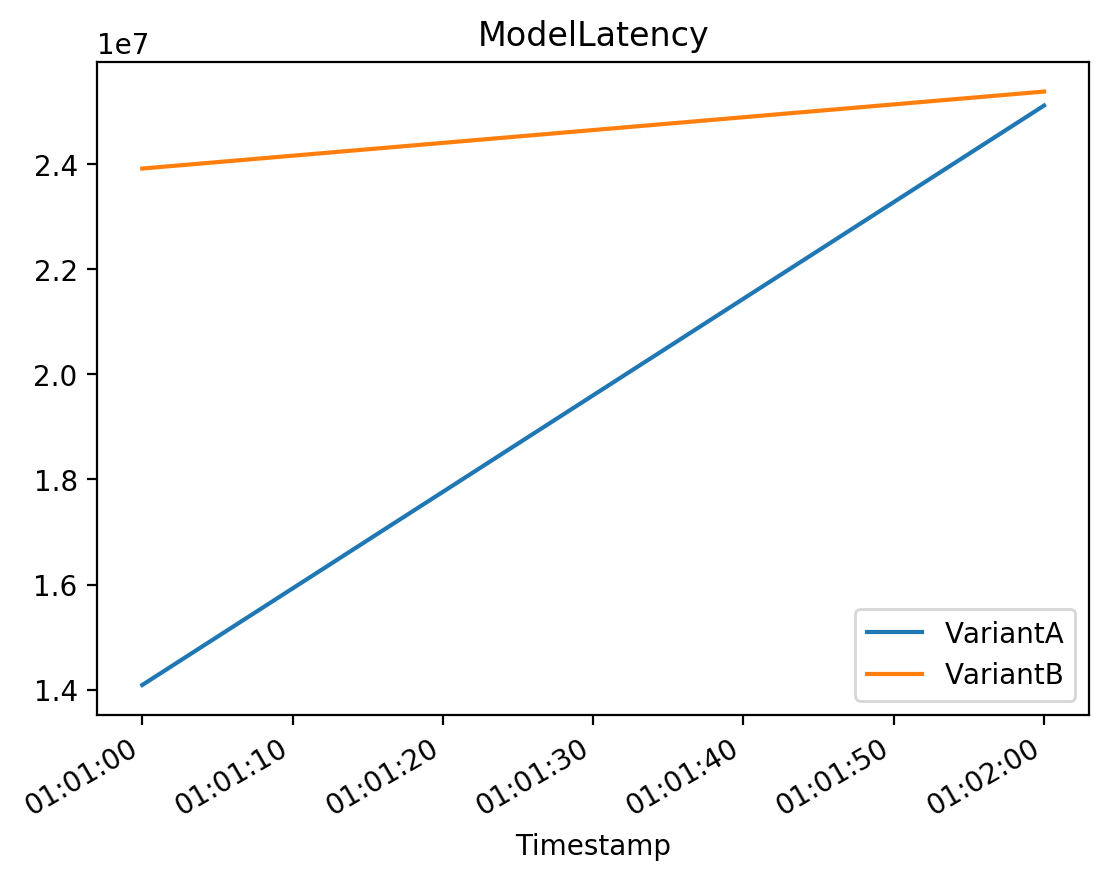

In [35]:
# ModelLatency
# The interval of time taken by a model to respond as viewed from SageMaker (in microseconds).
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="ModelLatency",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

<a name='c3w2-3.'></a>
# 3. Shift the traffic to one variant and review the endpoint performance metrics

Generally, the winning model would need to be chosen. The decision would be made based on the endpoint performance metrics and some other business related evaluations. Here you can assume that the winning model is in the Variant B and shift all traffic to it. 

Construct a list with the updated endpoint weights.

### _**No downtime** occurs during this traffic-shift activity._

### _This may take a few minutes. Please be patient._

In [36]:
updated_endpoint_config = [
    {
        "VariantName": variantA["VariantName"],
        "DesiredWeight": 0,
    },
    {
        "VariantName": variantB["VariantName"],
        "DesiredWeight": 100,
    },
]

<a name='c3w2-ex-8'></a>
### Exercise 8

Update variant weights in the configuration of the existing endpoint.

**Instructions**: Use the `sm.update_endpoint_weights_and_capacities` function, passing the endpoint name and list of updated weights for each of the variants that you defined above.

In [37]:
sm.update_endpoint_weights_and_capacities(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    EndpointName=model_ab_endpoint_name, # Replace None
    DesiredWeightsAndCapacities=updated_endpoint_config # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:795941057495:endpoint/ab-1676422139',
 'ResponseMetadata': {'RequestId': '972658a6-613e-44ad-a47d-9f302b3f5d37',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '972658a6-613e-44ad-a47d-9f302b3f5d37',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '81',
   'date': 'Wed, 15 Feb 2023 01:10:01 GMT'},
  'RetryAttempts': 0}}

_Wait for the ^^ endpoint update ^^ to complete above_

This may take a few minutes.  Please be patient.

### _There is **no downtime** while the update is applying._

While waiting for the update (or afterwards) you can review the endpoint in the AWS console.

**Instructions**:

- open the link
- notice that you are in the section Amazon SageMaker -> Endpoints
- check the name of the endpoint, its ARN and status (`Updating` or `InService`)
- below you can see the endpoint runtime settings with the updated weights

In [38]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST endpoint</a></b>'.format(region, model_ab_endpoint_name)))

In [39]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

Run some more predictions and view the metrics for each variant.

### _This cell will take approximately 1-2 minutes to run._

In [40]:
%%time

for i in range(0, 100):
    predicted_classes = predictor.predict(inputs)

CPU times: user 260 ms, sys: 10.9 ms, total: 271 ms
Wall time: 1min 28s


_Μake sure the predictions ^^ above ^^ ran successfully_

If you see `Metrics not yet available`, please be patient as metrics may take a few minutes to appear in CloudWatch. Compare the results with the plots above.

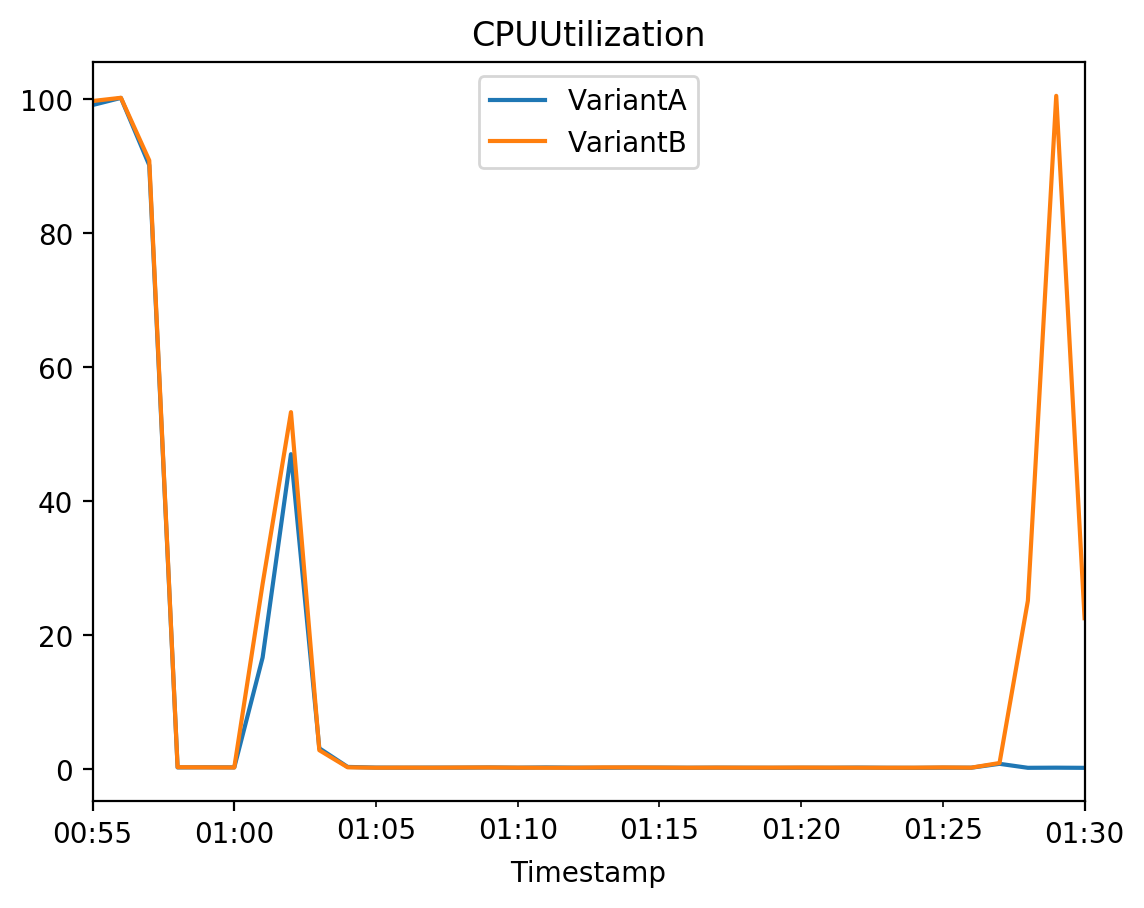

In [41]:
# CPUUtilization
# The sum of each individual CPU core's utilization. 
# The CPU utilization of each core can range between 0 and 100. For example, if there are four CPUs, CPUUtilization can range from 0% to 400%.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="/aws/sagemaker/Endpoints",
    metric_name="CPUUtilization",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

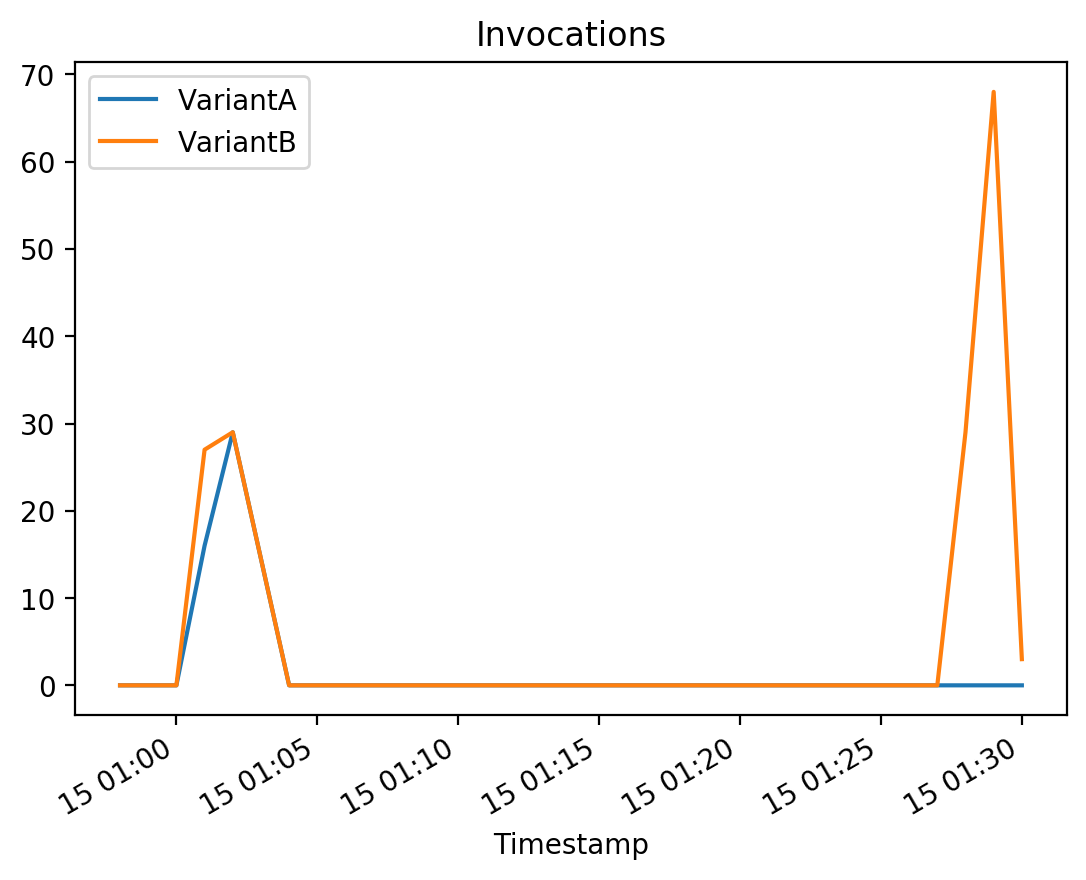

In [42]:
# Invocations
# The number of requests sent to a model endpoint.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="Invocations",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

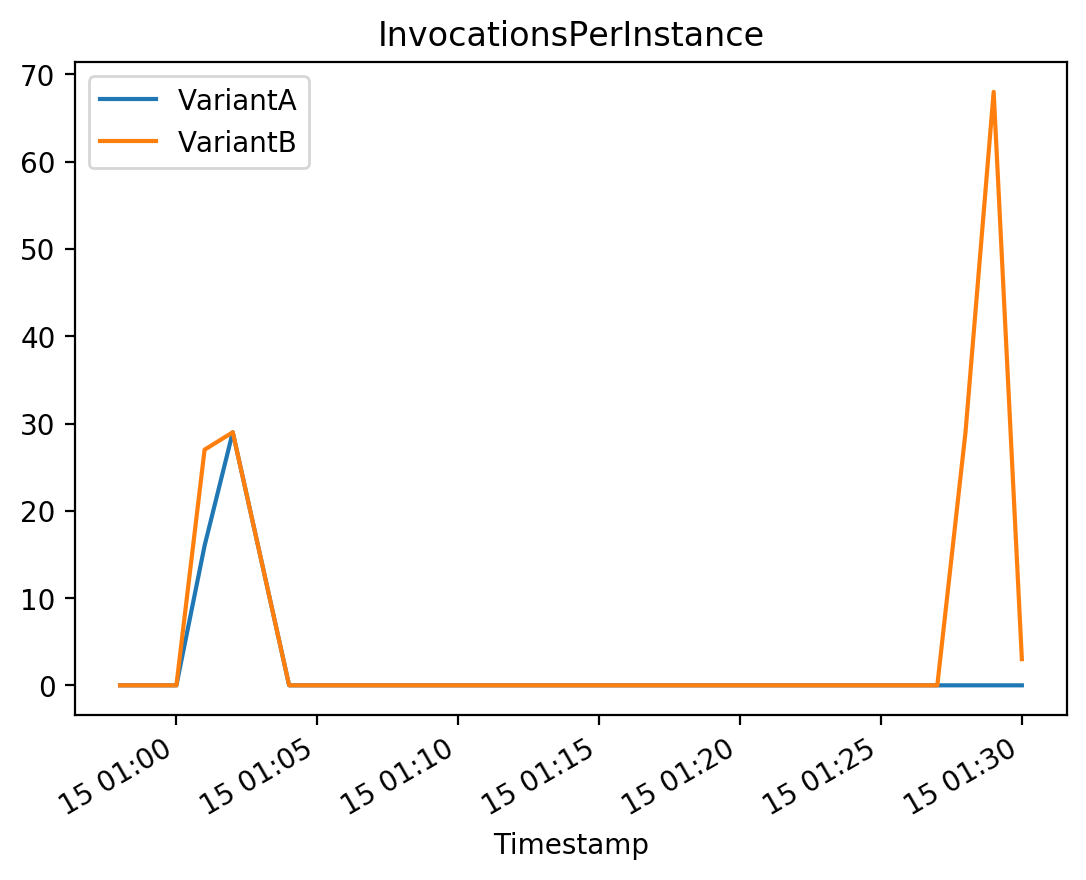

In [43]:
# InvocationsPerInstance
# The number of invocations sent to a model, normalized by InstanceCount in each production variant.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="InvocationsPerInstance",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

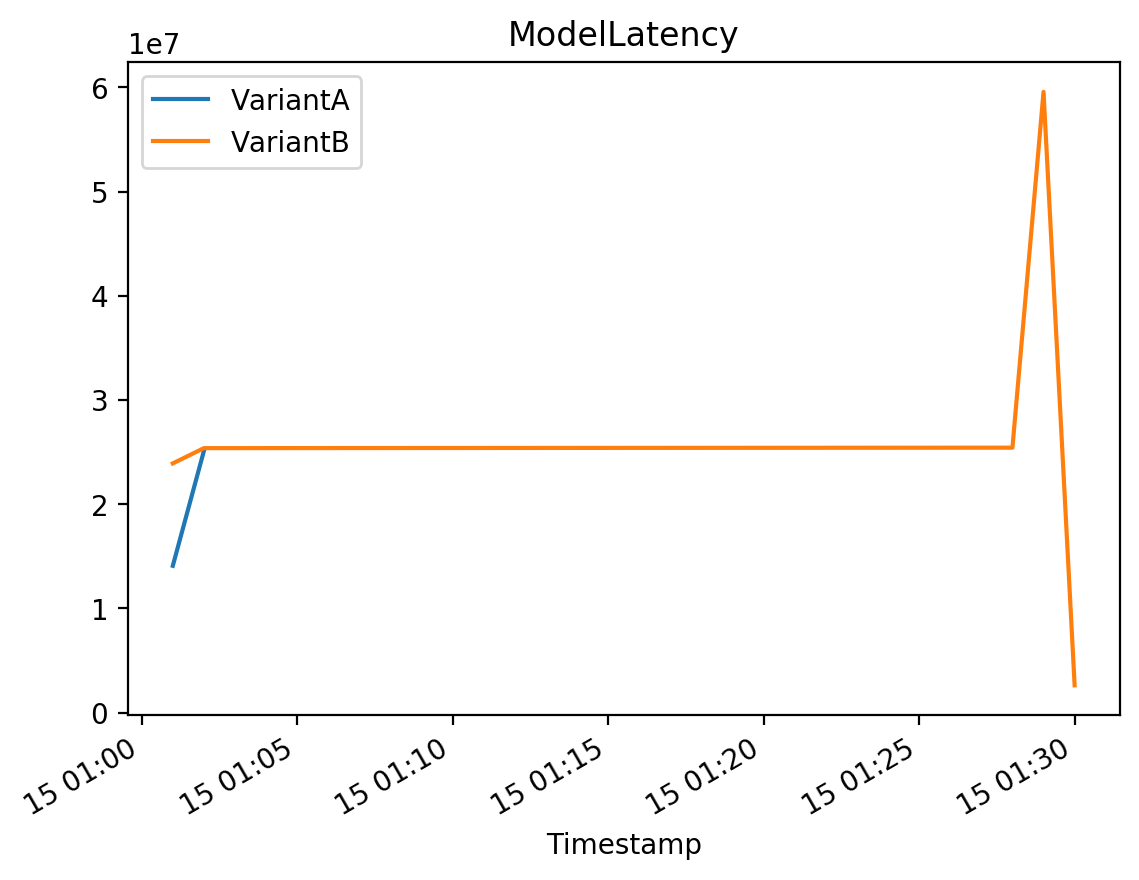

In [44]:
# ModelLatency
# The interval of time taken by a model to respond as viewed from SageMaker (in microseconds).
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="ModelLatency",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

<a name='c3w2-4.'></a>
# 4. Configure one variant to autoscale

Let's configure Variant B to autoscale. You would not autoscale Variant A since no traffic is being passed to it at this time.

First, you need to define a scalable target. It is an AWS resource and in this case you want to scale a `sagemaker` resource as indicated in the `ServiceNameSpace` parameter. Then the `ResourceId` is a SageMaker Endpoint. Because autoscaling is used by other AWS resources, you’ll see a few parameters that will remain static for scaling SageMaker Endpoints. Thus the `ScalableDimension` is a set value for SageMaker Endpoint scaling.

You also need to specify a few key parameters that control the min and max behavior for your Machine Learning instances. The `MinCapacity` indicates the minimum number of instances you plan to scale in to. The `MaxCapacity` is the maximum number of instances you want to scale out to. So in this case you always want to have at least 1 instance running and a maximum of 2 during peak periods. 

In [45]:
autoscale.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId="endpoint/" + model_ab_endpoint_name + "/variant/VariantB",
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=1,
    MaxCapacity=2,
    RoleARN=role,
    SuspendedState={
        "DynamicScalingInSuspended": False,
        "DynamicScalingOutSuspended": False,
        "ScheduledScalingSuspended": False,
    },
)

{'ResponseMetadata': {'RequestId': 'b0d1db1b-376c-46a9-b904-f8b75c83ca6c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b0d1db1b-376c-46a9-b904-f8b75c83ca6c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Wed, 15 Feb 2023 01:55:50 GMT'},
  'RetryAttempts': 0}}

In [46]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

Check that the parameters from the function above are in the description of the scalable target:

In [47]:
autoscale.describe_scalable_targets(
    ServiceNamespace="sagemaker",
    MaxResults=100,
)

{'ScalableTargets': [{'ServiceNamespace': 'sagemaker',
   'ResourceId': 'endpoint/ab-1676422139/variant/VariantB',
   'ScalableDimension': 'sagemaker:variant:DesiredInstanceCount',
   'MinCapacity': 1,
   'MaxCapacity': 2,
   'RoleARN': 'arn:aws:iam::795941057495:role/aws-service-role/sagemaker.application-autoscaling.amazonaws.com/AWSServiceRoleForApplicationAutoScaling_SageMakerEndpoint',
   'CreationTime': datetime.datetime(2023, 2, 15, 1, 55, 50, 662000, tzinfo=tzlocal()),
   'SuspendedState': {'DynamicScalingInSuspended': False,
    'DynamicScalingOutSuspended': False,
    'ScheduledScalingSuspended': False}}],
 'ResponseMetadata': {'RequestId': '243fed7a-d0a1-43dc-ad97-5cc66ba16b19',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '243fed7a-d0a1-43dc-ad97-5cc66ba16b19',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '522',
   'date': 'Wed, 15 Feb 2023 01:57:03 GMT'},
  'RetryAttempts': 0}}

Define and apply scaling policy using the `put_scaling_policy` function. The scaling policy provides additional information about the scaling behavior for your instance. `TargetTrackingScaling` refers to a specific autoscaling type supported by SageMaker, that uses a scaling metric and a target value as the indicator to scale.

In the scaling policy configuration, you have the predefined metric `PredefinedMetricSpecification` which is the number of invocations on your instance and the `TargetValue` which indicates the number of invocations per ML instance you want to allow before triggering your scaling policy. A scale out cooldown of 60 seconds means that after autoscaling successfully scales out it starts to calculate the cooldown time. The scaling policy won’t increase the desired capacity again until the cooldown period ends.

The scale in cooldown setting of 300 seconds means that SageMaker will not attempt to start another cooldown policy within 300 seconds of when the last one completed.

In [48]:
autoscale.put_scaling_policy(
    PolicyName="bert-reviews-autoscale-policy",
    ServiceNamespace="sagemaker",
    ResourceId="endpoint/" + model_ab_endpoint_name + "/variant/VariantB",
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    PolicyType="TargetTrackingScaling",
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 2.0, # the number of invocations per ML instance you want to allow before triggering your scaling policy
        "PredefinedMetricSpecification": {
            "PredefinedMetricType": "SageMakerVariantInvocationsPerInstance", # scaling metric
        },
        "ScaleOutCooldown": 60, # wait time, in seconds, before beginning another scale out activity after last one completes
        "ScaleInCooldown": 300, # wait time, in seconds, before beginning another scale in activity after last one completes
    },
)

{'PolicyARN': 'arn:aws:autoscaling:us-east-1:795941057495:scalingPolicy:f9a8050b-4a4c-4c88-8013-dc96a75bc767:resource/sagemaker/endpoint/ab-1676422139/variant/VariantB:policyName/bert-reviews-autoscale-policy',
 'Alarms': [{'AlarmName': 'TargetTracking-endpoint/ab-1676422139/variant/VariantB-AlarmHigh-cb904a0a-b1b3-407e-b2a1-adcd684e0c59',
   'AlarmARN': 'arn:aws:cloudwatch:us-east-1:795941057495:alarm:TargetTracking-endpoint/ab-1676422139/variant/VariantB-AlarmHigh-cb904a0a-b1b3-407e-b2a1-adcd684e0c59'},
  {'AlarmName': 'TargetTracking-endpoint/ab-1676422139/variant/VariantB-AlarmLow-bb0e3350-d7d5-4955-88dc-02e13252b7da',
   'AlarmARN': 'arn:aws:cloudwatch:us-east-1:795941057495:alarm:TargetTracking-endpoint/ab-1676422139/variant/VariantB-AlarmLow-bb0e3350-d7d5-4955-88dc-02e13252b7da'}],
 'ResponseMetadata': {'RequestId': 'fd32f613-8224-48cf-959c-62b206b404f4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'fd32f613-8224-48cf-959c-62b206b404f4',
   'content-type': 'ap

In [49]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

Generate traffic again and review the endpoint in the AWS console.

### _This cell will take approximately 1-2 minutes to run._

In [50]:
%%time

for i in range(0, 100):
    predicted_classes = predictor.predict(inputs)

CPU times: user 258 ms, sys: 9.76 ms, total: 268 ms
Wall time: 1min 29s


Review the autoscaling:

- open the link
- notice that you are in the section Amazon SageMaker -> Endpoints
- below you can see the endpoint runtime settings with the instance counts. You can run the predictions multiple times to observe the increase of the instance count to 2

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST endpoint</a></b>'.format(region, model_ab_endpoint_name)))


Upload the notebook into S3 bucket for grading purposes.

**Note:** you may need to click on "Save" button before the upload.

In [ ]:
!aws s3 cp ./C3_W2_Assignment.ipynb s3://$bucket/C3_W2_Assignment_Learner.ipynb